# Discounted Cash Flow
## Fair Stock Valuation Method
### Step 1: Forecast Free Cash Flows (FCF)
$$ \text{Free Cash Flow} = \text{Operating Cash Flow} - \text{Capital Expenditures} $$

In [89]:
from matplotlib import pyplot as plt
def cagr(start, finish, n_years):
    return ((finish / start)**(1/n_years)) - 1

fcf_blns = { 
    2024: 72.76, 
    2023: 69.5, 
    2022: 60.01, 
    2021: 67.01, 
    2020: 42.84, 
    2019: 30.97,
    2018: 22.83,
    2017: 23.91,
    2016: 25.82,
    2015: 16.62,
    2014: 11.42}
start_year = 2014
end_year = 2024
last_proj_year = 2029
last_fcf = fcf_blns[end_year]
fcf_cagr = cagr(start=fcf_blns[start_year], finish=fcf_blns[end_year], n_years=end_year - start_year)

def get_fcf_projections(last_year, last_fcf, cagr, n_of_years):
    fcf_proj = {}
    for yearI in range(1, n_of_years +1):
        year = last_year + yearI
        fcf_proj[year] = last_fcf * (1 + cagr) ** yearI
    return fcf_proj
fcf_proj_blns = get_fcf_projections(last_year=end_year, last_fcf=last_fcf, cagr=fcf_cagr, n_of_years=5)
all_fcf_blns = fcf_blns | fcf_proj_blns

def display_fcf(fcf_vals, end_year_real):
    colors = ['gray' if year > end_year_real else 'lightgreen' for year in fcf_vals.keys()]
    plt.figure(figsize=(16, 5))
    plt.title("Free Cash Flow")
    plt.bar(fcf_vals.keys(), fcf_vals.values(), color=colors, edgecolor='black')
    plt.xlabel("Year")
    plt.ylabel("Free Cash Flow (Billions)")
    plt.grid()


### Step 2: Get Discount Rate
#### 2.A: Calculate Cost of Equity
$$ r_e = R_f + \beta \times (R_m - R_f) $$
- $ R_f $ = Risk free rate
- $ \beta $ = Stock beta
- $ R_m $ = Expected market return



In [90]:
def get_cost_of_equity(risk_free_rate, expected_return, stock_beta):
    erf = expected_return - risk_free_rate
    return (risk_free_rate + stock_beta * erf)

#### 2.B: Calculate Cost of Debt
$$ r_a = \frac{\text{Interest Expense}}{\text{Total Debt}} $$


In [91]:
def get_cost_of_debt(interest_expense, total_debt):
    return interest_expense / total_debt

#### 2.C: Calculate the Weighted Average Cost of Capital
$$ \text{WACC} = (\frac{E}{V} \times r_e) + (\frac{D}{V} \times r_d \times (1 - T)) $$
- $ E = \text{Share Price} \times \text{Shares Outstanding} $ = Market value of equity
- $ D $ = Market value of debt
- $ V = E + D $ = Total value of capital
- $ r_e $ = Cost of equity
- $ r_d $ = Cost of debt
- $ T $ = Corporate tax rate

In [92]:
def get_wacc(share_price, shares_outstanding, total_debt, cost_of_debt, cost_of_equity, tax_rate):
    equity_value = share_price * shares_outstanding
    total_capital = equity_value + total_debt
    equity_weight = equity_value / total_capital
    debt_weight = total_debt / total_capital
    return (equity_weight * cost_of_equity) + (debt_weight * cost_of_debt * (1 - tax_rate))

### Step 3: Calculate the Present Value (PV) of Each Year's FCF
$$ \text{Present Value} = \frac{\text{FCF}_t}{(1+r)^t} $$

In [93]:
def get_present_value(val, discount, t_years):
    return val / ((1 + discount) ** t_years)
def get_discount_fcf(fcf_vals, discount):
    fcf_pv_vals = {}
    start_year = min(list(fcf_vals.keys()))
    for k, v in fcf_vals.items():
        n_year = k - start_year + 1
        fcf_pv_vals[k] = get_present_value(val=v, discount=discount, t_years=n_year)
    return fcf_pv_vals


### Step 4: Calculate Terminal Value (TV)
$$ \text{Terminal Value} = \frac{\text{FCF}_\text{final} \times (1 + g)}{r - g} $$
- $ r $ = Discount rate
- $ g $ = Terminal growth rate
$$ \text{PV}_\text{TV} = \frac{\text{TV}}{(1 + r)^t} $$

In [94]:
def get_terminal_value(last_fcf, growth_rate, discount_rate):
    return (last_fcf * (1 + growth_rate)) / (discount_rate - growth_rate)

### Step 5: Add All Present Values
$$ \text{Discounted Cash Flow} = \sum_{t=1}^n \frac{\text{FCF}_t}{(1 + r)^t} + \frac{\text{TV}}{(1 + r)^n} $$

$2,550,558,728,166.58


### Step 6: Adjust for Net Debt
$$ \text{Net Debt} = \text{Total Debt} - \text{Cash} $$
$$ \text{Fair Equity Value} = \text{DCF} - \text{Net Debt} $$


### Step 7: Divide by Shares Outstanding
$$ \text{Fair Value} = \frac{\text{Fair Equity Value}}{\text{Shares Outstanding}} $$

In [96]:
def get_stock_value(equity_value, shares_outstanding):
    return equity_value / shares_outstanding


## Bringing it All Together

Historical FCF Years: 2014 - 2024 (10 years)
Weighted Recent CAGR: 10.14%
Cost of Equity: 9.71%
Cost of Debt: 1.54%
Weighted Average Cost of Capital (WACC): 9.47%
Sum of PV FCF: $370,475,699,752.08
Terminal Value: $1,732,987,394,766.57
Present Value Terminal Value: $1,102,114,553,735.69
DCF: $1,472,590,253,487.77
Fair Equity Value: $1,539,420,253,487.77
Fair Value: $265.42


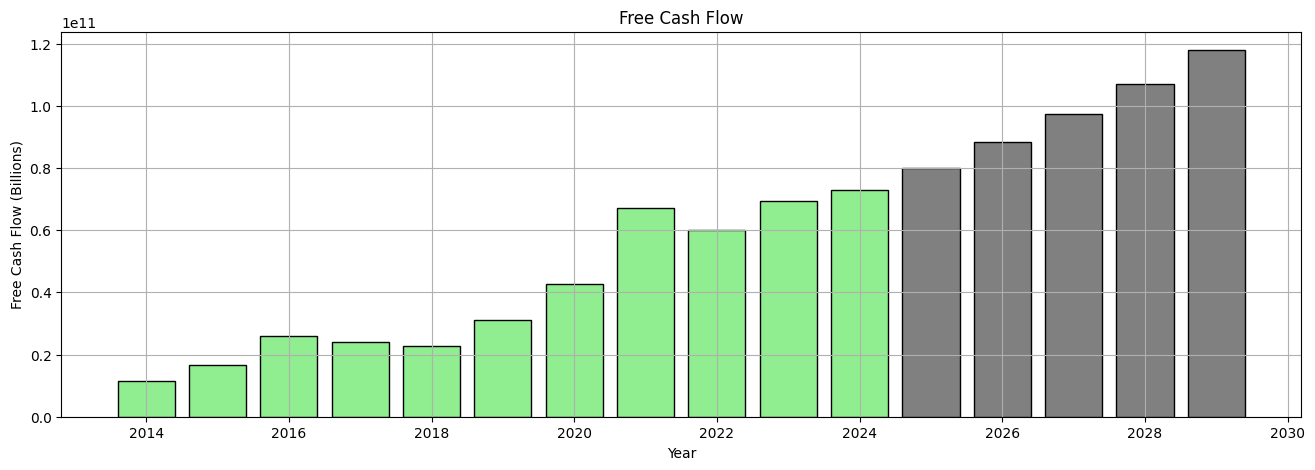

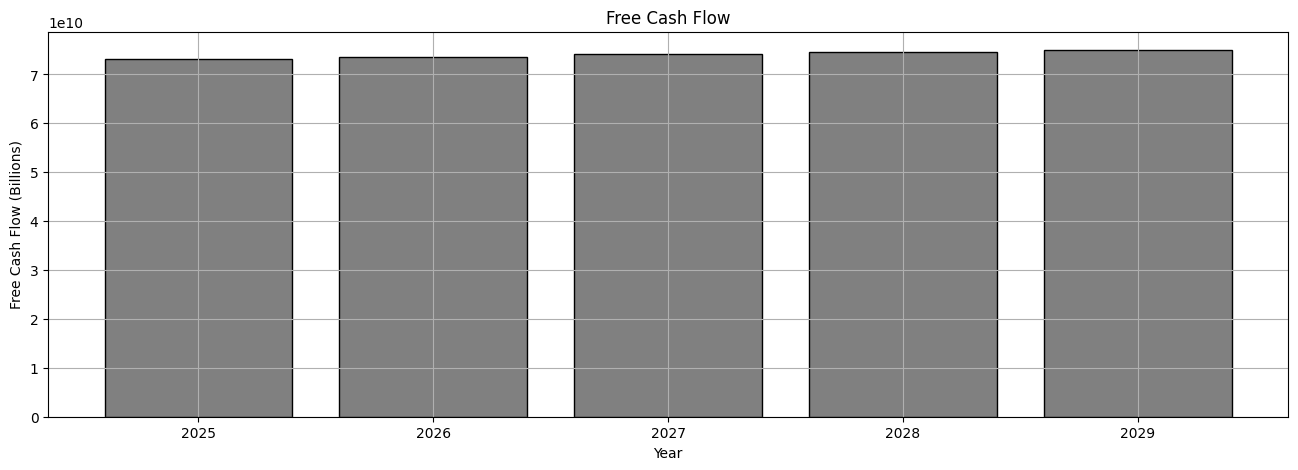

In [121]:
def get_weighted_recent_cagr(fcf_dict, reference_year=None):
    if reference_year is None:
        reference_year = max(fcf_dict.keys())
    cagr_contributions = []
    total_weight = 0
    for year, fcf in fcf_dict.items():
        if year >= reference_year:
            continue
        years_diff = reference_year - year
        if fcf <= 0:
            continue
        local_cagr = (fcf_dict[reference_year] / fcf) ** (1 / years_diff) - 1
        weight = 1 / years_diff # inversely proportional to how far back it is.
        cagr_contributions.append(local_cagr * weight)
        total_weight += weight
    if total_weight == 0:
        return 0
    return sum(cagr_contributions) / total_weight

fcf_years = { 
    2024: 72_760_000_000, 
    2023: 69_500_000_000, 
    2022: 60_010_000_000, 
    2021: 67_010_000_000,
    2020: 42_840_000_000, 
    2019: 30_970_000_000,
    2018: 22_830_000_000,
    2017: 23_910_000_000,
    2016: 25_820_000_000,
    2015: 16_620_000_000,
    2014: 11_420_000_000 
    }
def get_fair_value(share_price, fcf_vals, terminal_growth, shares_outstanding, total_debt, interest_expense, total_cash, tax_rate, risk_free_rate, expected_return, stock_beta):
    years = list(fcf_vals.keys())
    start_year = min(years)
    end_year = max(years)
    total_years = end_year - start_year
    print(f"Historical FCF Years: {start_year} - {end_year} ({total_years} years)")
    weighted_fcf_cagr = get_weighted_recent_cagr(fcf_vals)
    print(f"Weighted Recent CAGR: {weighted_fcf_cagr*100:.2f}%")
    forecast_years_n = 5
    fcf_proj = get_fcf_projections(last_year=end_year, last_fcf=fcf_vals[end_year], cagr=weighted_fcf_cagr, n_of_years=forecast_years_n)
    
    all_fcf = fcf_years | fcf_proj
    display_fcf(all_fcf, end_year)
    cost_of_equity = get_cost_of_equity(risk_free_rate, expected_return, stock_beta)
    cost_of_debt = get_cost_of_debt(interest_expense, total_debt)
    wacc = get_wacc(share_price, shares_outstanding, total_debt, cost_of_debt, cost_of_equity, tax_rate)
    print(f"Cost of Equity: {cost_of_equity*100:.2f}%")
    print(f"Cost of Debt: {cost_of_debt*100:.2f}%")
    print(f"Weighted Average Cost of Capital (WACC): {wacc*100:.2f}%")
    pv_fcf_proj = get_discount_fcf(fcf_vals=fcf_proj, discount=wacc)
    sum_pv_fcf_proj = sum(list(pv_fcf_proj.values()))
    print(f"Sum of PV FCF: ${sum_pv_fcf_proj:,.2f}")
    display_fcf(fcf_vals=pv_fcf_proj, end_year_real=end_year)
    last_proj_year = max(fcf_proj.keys())
    final_fcf = fcf_proj[last_proj_year]
    terminal_value = get_terminal_value(final_fcf, terminal_growth, wacc)
    print(f"Terminal Value: ${terminal_value:,.2f}")
    pv_terminal_val = get_present_value(val=terminal_value, discount=wacc, t_years=forecast_years_n)
    print(f"Present Value Terminal Value: ${pv_terminal_val:,.2f}")
    dcf = pv_terminal_val + sum_pv_fcf_proj
    print(f"DCF: ${dcf:,.2f}")
    net_debt = total_debt - total_cash
    fair_equity_value = dcf - net_debt
    print(f"Fair Equity Value: ${fair_equity_value:,.2f}")
    fair_value = fair_equity_value / shares_outstanding
    print(f"Fair Value: ${fair_value:,.2f}")
    
googl_fair_value = get_fair_value(
    share_price=176.79,
    fcf_vals=fcf_years,
    terminal_growth=0.025,
    shares_outstanding=5_800_000_000,
    total_debt = 28_500_000_000,
    total_cash=95_330_000_000,
    interest_expense=438_000_000,
    risk_free_rate=0.0412,
    expected_return=0.10,
    stock_beta=0.95,
    tax_rate=0.25
)